# Learning states with conventional experiment

Using randomized Pauli measurement from https://www.nature.com/articles/s41567-020-0932-7 to predict which of the two Pauli observables have a higher magnitude of expectation value.
The number of experiments need to scale exponentially with the system size $n$ to make accurate prediction.

We perform measurement error mitigation as described in the manuscript (Appendix A.2.d).

In [1]:
import numpy as np
from scipy.stats import moment
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from os import listdir
import random
from os.path import isfile, join

idx_to_pauli = ["Z", "X", "Y"]

# Measurement-error-mitigated expectation value prediction
def predict_exp(data, list_P, calib_2x2, inverse_cnt=20):
    ttl_sum, ttl_cnt = 0, 0

    for rep in range(inverse_cnt):
        for _, a in enumerate(data):
            val = 1
            
            for i, pauli in enumerate(list_P):
                if pauli == "I": continue

                p1, q1 = calib_2x2[2*i][0, 0], calib_2x2[2*i][1, 1]
                
                val *= 1 / (p1 + q1 - 1)
                
                a[i] = int(a[i])
                b1 = int(a[i] // 2)
                s1 = int(a[i] % 2)

                if s1 == 0:
                    if random.choices([0, 1], weights = [q1, 1-q1], k=1)[0] == 1:
                        s1 = 1 - s1
                        val *= -1
                else:
                    if random.choices([0, 1], weights = [p1, 1-p1], k=1)[0] == 1:
                        s1 = 1 - s1
                        val *= -1

                if idx_to_pauli[b1] == pauli:
                    val *= (1 if s1 == 0 else -1)
                else:
                    val = 0
            
            if val != 0:
                ttl_sum += val
                ttl_cnt += 1
    return (ttl_sum / ttl_cnt if ttl_cnt > 0 else None)

mypath = "data/"

n = 8
number_of_experiment = 500
correct_cnt, total_cnt = 0, 0

# Noiseless simulation (measurement error = 0)
calib_2x2 = []
for i in range(2*n):
    conf_mtx = np.zeros((2, 2))
    conf_mtx[0][0] = 1
    conf_mtx[0][1] = 0
    conf_mtx[1][0] = 0
    conf_mtx[1][1] = 1
    calib_2x2.append(conf_mtx)

onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for file in onlyfiles * 5:
    splt = file.split("-")

    if splt[0] != "C": continue
    if int(splt[2]) != n: continue
    if len(splt) != 5: continue

    pauli = splt[-1][:-4]

    binaryout = np.load(join(mypath, file))
    basisout = np.load(join(mypath, "-".join(splt[:-1]) + "-" + splt[-1][:-4] + "-basis.npy"))
    fulldata = basisout*2 + binaryout

    data = np.random.permutation(fulldata)[:number_of_experiment]

    rand_P = [random.choice(["I", "X", "Y", "Z"]) for i in range(n)]
    while min([x == y for (x, y) in zip(pauli, rand_P)]) == 1 or sum([p == "I" for p in rand_P]) == (n):
        rand_P = [random.choice(["I", "X", "Y", "Z"]) for i in range(n)]

    pred1 = predict_exp(data, pauli, calib_2x2)
    pred2 = predict_exp(data, rand_P, calib_2x2)
    
    if pred1 is None or pred2 is None:
        correct_cnt += 0.5
    elif abs(pred1) > abs(pred2):
        correct_cnt += 1
    total_cnt += 1

print("ACC:", correct_cnt / total_cnt)


ACC: 0.465


# Learning states with quantum-enhanced experiments

We begin by presenting the supervised neural network model described in the manuscript (See Appendix A.2.d).

We train a supervised neural network model using noiseless simulation data from small system sizes. Then we use the trained neural network model on the noisy experimental data obtained from performing quantum-enhanced experiments. The neural network model has three layers. Each of the outer layers runs the preceding inner layer multiple times. In the following, we describe each layer of the neural network model.

We begin with the inner layer, which is given by the following code block.
Only the inner layer contains trainable parameters. The intermediate layer and the outer layer are both fixed operations based on outputs from the inner layer, which will go through back-propagation but will not be updated.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class CharRNN(nn.Module):
    def __init__(self):
        super(CharRNN, self).__init__()
        self.encoder = nn.Embedding(16, 30)
        self.rnn = nn.GRU(30, 30, 1)
        self.decoder = nn.Linear(30, 2)

    def forward(self, input, hidden):
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1)).view(batch_size, -1)
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(1, batch_size, 30))

decoder = CharRNN()
decoder_optimizer = torch.optim.Adam(decoder.parameters())
criterion = nn.CrossEntropyLoss()

Next, we discuss the training process in the neural network model.
We use noiseless simulation data (for small system sizes $n < 8$) to train the recurrent neural network.
During training, we pick a state $\rho = 2^{-n}\left(I+ \alpha P\right)$ where $\alpha \in \{-0.95, 0.95\}$ and $P$ is an $n$-qubit Pauli operator, and pick an $n$-qubit Pauli operator $Q$ that is equal to $P$ with probability $1/2$ and is not equal to $P$ with probability $1/2$.
We encode the training data into two Pytorch Variable LongTensors, `inp` and `target`.
The encoding is defined by the following.

1. The Pytorch Variable LongTensor `inp` is a tensor of size $b \times n$, where $b$ is the number of quantum-enhanced experiments we performed, $n$ is the number of qubits, and each entry of `inp` is an integer from $0$ to $15$.
    The $(t, i)$-th entry of `inp` encodes the component of $Q$ on qubit $i$ (a choice of $4$ for $I, X, Y, Z$) and the Bell measurement outcome on qubit $i$ from the $t$-th quantum-enhanced experiment (also a choice of $4$).
    Each entry takes a total of $16$ possible values.
    
    
2. The Pytorch Variable LongTensor `target` is a tensor of size $1$. The entry in `target` is equal to $1$ if $P = Q$, and is equal to $0$ if $P \neq Q$.

Given `inp` of size $b \times n$ and `target` of size $1$, we train the neural network model using the code block below.
We are using the cross entropy loss, `criterion = nn.CrossEntropyLoss()` from the previous code block, and employ the Adam optimizer, which is a gradient-based optimization algorithm that adaptively estimates lower-order moments.

In [3]:
def train(inp, target, b, n):
    decoder.train()
    
    hidden = decoder.init_hidden(b)
    decoder.zero_grad()
    loss = 0
    for c in range(n):
        output, hidden = decoder(inp[:,c], hidden)
        if c == n-1:
            loss += criterion(torch.mean(output.view(b, -1), dim=0, keepdim=True),\
                              target[:])

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item()


Also, we are simultaneously running the $b$ repetitions of the inner layer for each outcome from a single quantum-enhanced experiment in the line `output, hidden = decoder(inp[:,c], hidden)` to leverage parallel computing.
Then, we average over the $b$ repetitions of the inner layer through `torch.mean(output.view(b, -1), dim=0, keepdim=True)`.
Also, note that `torch.mean(output.view(b, -1), dim=0, keepdim=True)` is a two-dimensional real vector, denoted as $v = (v_0, v_1)$.
When `target` is $a \in \{0, 1\}$, the loss function is given by
\begin{equation}
    -\log\left( \frac{\mathrm{e}^{v_a}}{\mathrm{e}^{v_0} + \mathrm{e}^{v_1}} \right).
\end{equation}
The two real values $v_0$, $v_1$ are combined to produce a probability distribution
\begin{equation} \label{eq:prob-NN}
    \frac{\mathrm{e}^{v_0}}{\mathrm{e}^{v_0} + \mathrm{e}^{v_1}} = 1 - \frac{1}{\mathrm{e}^{v_0 - v_1} + 1}, \quad \frac{\mathrm{e}^{v_1}}{\mathrm{e}^{v_0} + \mathrm{e}^{v_1}} = \frac{1}{\mathrm{e}^{v_0 - v_1} + 1},
\end{equation}
indicating which of $a=0$ and $a=1$ is more likely.
If $v_0 - v_1$ is large, then $a=0$ corresponding to $P \neq Q$ is more likely. On the other hand, if $v_0 - v_1$ is small, then $a=1$ corresponding to $P = Q$ is more likely.
The two lines `loss.backward()` and `decoder_optimizer.step()` computes the gradient through back-propagation and update the model using the rule given in Adam optimizer.


Finally, we discuss the prediction process in the neural network model.
Due to the significant amount of measurement errors, we employ a form of measurement error mitigation.
We first characterize the measurement errors for every qubit assuming the zero state preparations and $X$-gates are perfect.
For each qubit $i$, we obtain a $2\times 2$ matrix specifying the probability to measure $0$ or $1$ if the qubit is in $\lvert 0 \rangle\!\langle 0\rvert$ or $\lvert 1 \rangle\!\langle 1\rvert$.
We store that as a list of $2 \times 2$ NumPy array called `calib_2x2`.
We then expand the data, referred to as `data` in the Python code, obtained from the quantum-enhanced experiments, which is a two-dimensional NumPy array of size $b \times (2n)$.
Basically, we expand each measurement to $20$ measurements with a real-valued coefficient associated to each of the expanded measurements.
Therefore, `data_expanded` is a two-dimensional array of size $(20 b) \times (2n)$ and `coefficients` is a one-dimensional array of size $20 b$.


In [4]:
import random

def noise_inversion(data, calib_2x2, inverse_cnt=20):
    data_expanded, coefficients = [], []
    for t in range(len(data)):
        for r in range(inverse_cnt):
            val = 1.0
            single_data = []
            
            for i in range(len(data[t])):
                s1 = data[t][i]
                p = calib_2x2[i][1, 1] if s1 == 0 else calib_2x2[i][0, 0]
                if random.choices([0, 1], weights = [p, 1-p], k=1)[0] == 1:
                    s1 = 1 - s1
                    val *= -1
                single_data.append(s1)

            data_expanded.append(single_data)
            coefficients.append(val)
    return data_expanded, coefficients

After obtaining `data_expanded`, we construct two Pytorch Variable LongTensor `inp1` and `inp2`.
Both are tensors of size $(20 b) \times n$, where $b$ is the number of quantum-enhanced experiments we performed, $n$ is the number of qubits, and each entry of `inp1` and `inp2` is an integer from $0$ to $15$ similar to the training process.
Then the neural network make a prediction using the following code.


In [5]:
def predict_one(inp, coefficients, n):
    decoder.eval()

    hidden = decoder.init_hidden(len(inp))
    decoder.zero_grad()
    for c in range(n):
        output, hidden = decoder(inp[:,c], hidden)
        if c == n-1:
            pred = torch.matmul(coefficients, output.view(len(inp), -1)).view(2).detach().numpy()
    return pred

def predict(inp1, coef1, inp2, coef2, n):
    pred1 = predict_one(inp1, coef1, n)
    pred2 = predict_one(inp2, coef2, n)

    return 1 if (pred1[0] - pred1[1]) < (pred2[0] - pred2[1]) else 2


We consider `pred1[0] - pred1[1]` based on the discussion above.
If `pred1[0] - pred1[1]` is small, then it is more likely that $P = Q_1$.
If `pred1[0] - pred1[1]` is small, then it is more likely that $P = Q_2$.

We now present the complete code for training the neural network and making predictions on the data.

In [6]:
from tqdm import tqdm
import cirq
import numpy as np
from os import listdir
import random
from os.path import isfile, join
from cirq import Simulator
simulator = Simulator()

all_paulis = dict([("I",0), ("X",1), ("Y",2), ("Z",3)])

def entire_process_predict_Pauli_observable(qubits, hidden_P, num_rep):
    n = len(qubits) // 2
    output = []
    
    sign_p = -1 if np.random.random() < 0.5 else 1
    for _ in range(num_rep):
        circuit = cirq.Circuit()

        last_i = 0
        for i, pauli in enumerate(hidden_P):
            if pauli != "I":
                last_i = i
            
        for twocopy in [0, 1]:
            parity = sign_p
            for i, pauli in enumerate(hidden_P):
                if pauli != "I":
                    if last_i == i:
                        if parity == -1:
                            circuit += cirq.X(qubits[2*i+twocopy])
                    elif random.choice([0, 1]) == 1:
                        parity *= -1
                        circuit += cirq.X(qubits[2*i+twocopy])
                else:
                    if random.choice([0, 1]) == 1:
                        circuit += cirq.X(qubits[2*i+twocopy])

                if pauli == "X":
                    circuit += cirq.H(qubits[2*i+twocopy])
                if pauli == "Y":
                    circuit += cirq.H(qubits[2*i+twocopy])
                    circuit += cirq.S(qubits[2*i+twocopy])

        for i, pauli in enumerate(hidden_P):
            circuit += cirq.CNOT(qubits[2*i], qubits[2*i+1])
            circuit += cirq.H(qubits[2*i])

        for i, qubit in enumerate(qubits):
            circuit += cirq.measure(qubit, key='q{}'.format(i))

        samples = simulator.run(circuit, repetitions=1)

        raw_samples = np.zeros(len(qubits), dtype=int)
        for i in range(len(qubits)):
            raw_samples[i] = samples.data['q{}'.format(i)]

        output.append(raw_samples)

    return output

def sample_one(b_experi, n_qubits):
    qubits = cirq.GridQubit.rect(n_qubits, 2)

    true_p = [random.choice(["I", "X", "Y", "Z"]) for i in range(n_qubits)]
    while sum([p == "I" for p in true_p]) == n_qubits:
        true_p = [random.choice(["I", "X", "Y", "Z"]) for i in range(n_qubits)]
    data = entire_process_predict_Pauli_observable(qubits, true_p, b_experi)

    true_or_fake = random.choice([0, 1])

    rand_P = [random.choice(["I", "X", "Y", "Z"]) for i in range(n_qubits)]
    while min([x == y for (x, y) in zip(true_p, rand_P)]) == 1 or sum([p == "I" for p in rand_P]) == n_qubits:
        rand_P = [random.choice(["I", "X", "Y", "Z"]) for i in range(n_qubits)]
    
    fake_p = true_p if true_or_fake == 1 else rand_P
    
    input_X = np.zeros((len(data), n_qubits))
    for i in range(len(data)):
        for j in range(0, len(data[i]), 2):
            input_X[i][j//2] = data[i][j]*2 + data[i][j+1]
            input_X[i][j//2] += all_paulis[fake_p[j//2]] * 4

    return input_X, true_or_fake

def random_training_set(b_experi, n_qubits):
    input_X, true_or_fake = sample_one(b_experi, n_qubits)

    inp = torch.LongTensor(input_X)
    target = torch.LongTensor(1)
    target[0] = true_or_fake

    inp = Variable(inp)
    target = Variable(target)
    return inp, target

def construct_from_exp(data, chosen_pauli, calib_2x2, n_qubits):
    data, coef = noise_inversion(data, calib_2x2, inverse_cnt=20)

    input_X = np.zeros((len(data), n_qubits))
    for i in range(len(data)):
        for j in range(0, len(data[i]), 2):
            input_X[i][j//2] = data[i][j]*2 + data[i][j+1]
            input_X[i][j//2] += all_paulis[chosen_pauli[j//2]] * 4
    inp = torch.LongTensor(input_X)
    inp = Variable(inp)

    coe_sign = torch.FloatTensor(coef) / len(coef)
    
    return inp, coe_sign

def get_accuracy(n):
    mypath = "data/"
    correct_cnt, total_cnt = 0, 0
    
    # Noiseless simulation (measurement error = 0)
    calib_2x2 = []
    for i in range(2*n):
        conf_mtx = np.zeros((2, 2))
        conf_mtx[0][0] = 1
        conf_mtx[0][1] = 0
        conf_mtx[1][0] = 0
        conf_mtx[1][1] = 1
        calib_2x2.append(conf_mtx)

    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    for file in onlyfiles * 2:
        splt = file.split("-")
        
        if splt[0] != "Q": continue
        if int(splt[2]) != n: continue
        
        true_P = splt[-1][:-4]
        data = np.random.permutation(np.load(join(mypath, file)))

        rand_P = [random.choice(["I", "X", "Y", "Z"]) for i in range(n)]
        while min([x == y for (x, y) in zip(true_P, rand_P)]) == 1 or sum([p == "I" for p in rand_P]) == n:
            rand_P = [random.choice(["I", "X", "Y", "Z"]) for i in range(n)]

        pred = predict(*construct_from_exp(data, true_P, calib_2x2, n),
                       *construct_from_exp(data, rand_P, calib_2x2, n), n)

        if pred == 1:
            correct_cnt += 1
        total_cnt += 1

    return correct_cnt / total_cnt

print("Training for %d examples..." % 10000)

store_all_loss = []
store_all_acc = []
for epoch in tqdm(range(1, 3000 + 1), position=0, leave=True):
    n_qubits = random.choice(range(2, min(8, 4 + (epoch // 1000))))
    loss = train(*random_training_set(15, n_qubits), 15, n_qubits)
    store_all_loss.append(loss)

    if epoch % 100 == 0:
        print("LOSS", np.mean(store_all_loss[-100:]))
    if epoch % 250 == 0:
        n = 8 # predict on data for system size n = 8
        store_all_acc.append(get_accuracy(n))
        print("ACC", store_all_acc[-1])

  0%|                                          | 1/3000 [00:00<05:08,  9.74it/s]

Training for 10000 examples...


  3%|█▎                                      | 101/3000 [00:07<04:04, 11.86it/s]

LOSS 0.7010987719893456


  7%|██▋                                     | 201/3000 [00:17<03:26, 13.57it/s]

LOSS 0.7056578263640404


  8%|███▏                                  | 252/3000 [01:11<4:30:58,  5.92s/it]

ACC 0.35


 10%|████                                    | 302/3000 [01:15<03:25, 13.15it/s]

LOSS 0.6880712875723839


 13%|█████▎                                  | 402/3000 [01:22<03:25, 12.65it/s]

LOSS 0.6891044595837593


 17%|██████▋                                 | 498/3000 [01:30<03:23, 12.29it/s]

LOSS 0.6756314340233803


 17%|██████▎                               | 502/3000 [02:16<3:22:40,  4.87s/it]

ACC 0.525


 20%|████████                                | 602/3000 [02:24<02:59, 13.39it/s]

LOSS 0.6718862247467041


 23%|█████████▎                              | 702/3000 [02:32<03:02, 12.62it/s]

LOSS 0.634903935790062


 25%|█████████▌                            | 752/3000 [03:23<3:07:46,  5.01s/it]

ACC 0.425


 27%|██████████▋                             | 802/3000 [03:27<02:48, 13.03it/s]

LOSS 0.6466570368409157


 30%|████████████                            | 902/3000 [03:35<02:51, 12.26it/s]

LOSS 0.5890597422420979


 33%|█████████████▎                          | 998/3000 [03:42<02:26, 13.63it/s]

LOSS 0.5411157709360123


 33%|████████████▎                        | 1001/3000 [04:30<3:17:40,  5.93s/it]

ACC 0.65


 37%|██████████████▎                        | 1100/3000 [04:39<02:48, 11.27it/s]

LOSS 0.4691870480775833


 40%|███████████████▌                       | 1201/3000 [04:48<02:38, 11.36it/s]

LOSS 0.3367442492954433


 42%|███████████████▍                     | 1251/3000 [05:46<3:41:02,  7.58s/it]

ACC 1.0


 43%|████████████████▉                      | 1300/3000 [05:51<02:59,  9.45it/s]

LOSS 0.247039335956797


 47%|██████████████████▏                    | 1400/3000 [06:02<02:29, 10.70it/s]

LOSS 0.13162528837798163


 50%|███████████████████▍                   | 1498/3000 [06:11<02:17, 10.91it/s]

LOSS 0.10982349822064862


 50%|██████████████████▌                  | 1502/3000 [06:58<2:03:20,  4.94s/it]

ACC 1.0


 53%|████████████████████▊                  | 1602/3000 [07:06<01:47, 13.04it/s]

LOSS 0.12103115448204335


 57%|██████████████████████▏                | 1702/3000 [07:15<01:59, 10.90it/s]

LOSS 0.09271536265936448


 58%|█████████████████████▌               | 1751/3000 [08:06<2:01:00,  5.81s/it]

ACC 1.0


 60%|███████████████████████▍               | 1801/3000 [08:10<01:32, 12.94it/s]

LOSS 0.05863530368718784


 63%|████████████████████████▋              | 1902/3000 [08:19<01:53,  9.68it/s]

LOSS 0.07748784126131796


 67%|█████████████████████████▉             | 1999/3000 [08:29<01:58,  8.45it/s]

LOSS 0.05077959488233318


 67%|████████████████████████▋            | 2001/3000 [09:26<2:54:39, 10.49s/it]

ACC 1.0


 70%|███████████████████████████▎           | 2101/3000 [09:38<01:40,  8.92it/s]

LOSS 0.06307093953641014


 73%|████████████████████████████▌          | 2201/3000 [09:52<01:42,  7.82it/s]

LOSS 0.07622316960681928


 75%|███████████████████████████▊         | 2251/3000 [10:57<1:38:08,  7.86s/it]

ACC 1.0


 77%|█████████████████████████████▉         | 2301/3000 [11:02<01:23,  8.35it/s]

LOSS 0.037912848099367694


 80%|███████████████████████████████▏       | 2401/3000 [11:14<01:10,  8.50it/s]

LOSS 0.03832163298844535


 83%|████████████████████████████████▍      | 2499/3000 [11:30<01:29,  5.57it/s]

LOSS 0.02484862251330469


 83%|██████████████████████████████▊      | 2501/3000 [12:30<1:43:46, 12.48s/it]

ACC 1.0


 87%|█████████████████████████████████▊     | 2601/3000 [12:40<00:45,  8.84it/s]

LOSS 0.04351241139576814


 90%|███████████████████████████████████    | 2700/3000 [12:51<00:28, 10.46it/s]

LOSS 0.03283559548246558


 92%|███████████████████████████████████▊   | 2751/3000 [13:49<31:55,  7.69s/it]

ACC 1.0


 93%|████████████████████████████████████▍  | 2802/3000 [13:55<00:21,  9.22it/s]

LOSS 0.027417695932817877


 97%|█████████████████████████████████████▋ | 2900/3000 [14:05<00:08, 11.27it/s]

LOSS 0.018936340993477643


100%|██████████████████████████████████████▉| 2999/3000 [14:18<00:00,  4.79it/s]

LOSS 0.02224759492623889


100%|███████████████████████████████████████| 3000/3000 [15:09<00:00,  3.30it/s]

ACC 1.0


# Learning dynamics with conventional experiments

Using kernel principal component analysis to analyze data from conventional experiments.

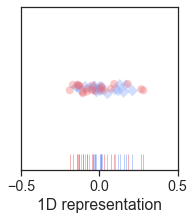

In [8]:
import numpy as np
from scipy.stats import moment
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from os import listdir
import random
from os.path import isfile, join
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA

np.random.seed(200)
sns.set(font_scale=1.3)
sns.set_style("ticks")

number_of_experiment = 50

fig=plt.figure(figsize=(1.4*2, 1.5*2))
mypath = "./data"

full_data = []
for size in [8]:
    full_X = []
    label = []
    
    for depth in [5]:
        config = "1D-scramble-C-size-{}-depth-{}-".format(size, depth)

        list_pred = []
        for b in range(0, 20, 5):
            for i in range(0, 5):
                data = np.load(join(mypath, config+'type-0-batch-{}-number-{}.npy'.format(b, i)))
                data = np.random.permutation(data)[:number_of_experiment]
                feature_vec = np.concatenate((np.mean(data, axis=0), [np.std(np.mean(data, axis=0))]))
                
                full_X.append(feature_vec)
                label.append(["General", depth])

    for depth in [5]:
        config = "1D-scramble-C-size-{}-depth-{}-".format(size, depth)

        for b in range(0, 20, 5):
            for i in range(0, 5):
                data = np.load(join(mypath, config+'type-1-batch-{}-number-{}.npy'.format(b, i)))
                data = np.random.permutation(data)[:number_of_experiment]
                feature_vec = np.concatenate((np.mean(data, axis=0), [np.std(np.mean(data, axis=0))]))

                full_X.append(feature_vec)
                label.append(["T-symmetry", depth])

    full_X = np.array(full_X)
    min_max_scaler = preprocessing.MinMaxScaler()
    full_X = min_max_scaler.fit_transform(full_X)* 0.8
    transformer = KernelPCA(n_components=2, kernel='rbf')
    X_transformed = transformer.fit_transform(full_X)

    full_data.extend([x + y for x, y in zip(X_transformed.tolist(), label)])
    
df = pd.DataFrame(full_data, columns=['x', 'y', 'Evolution', 'Depth'])


sns.rugplot(data=df[df["Evolution"]=="General"], x="x", hue="Evolution", alpha=.5, height=0.1, palette=["#80A3FA"])
sns.rugplot(data=df[df["Evolution"]=="T-symmetry"], x="x", hue="Evolution", alpha=.5, height=0.1, palette=["#ED686D"])
g = sns.stripplot(data=df[df["Evolution"]=="General"], x="x", hue="Evolution", marker="D", jitter=0.03, size=8, alpha=0.35, palette=["#80A3FA"])
g.set(yticks=[])
g = sns.stripplot(data=df[df["Evolution"]=="T-symmetry"], x="x", hue="Evolution", marker="o", jitter=0.03, size=8, alpha=0.35, palette=["#ED686D"])
g.set(yticks=[])
plt.xlim(-0.5, 0.5)
plt.xlabel("1D representation")
plt.ylabel("")

plt.legend([], [], frameon=[])


# Learning dynamics with quantum-enhanced experiments

Using kernel principal component analysis to analyze data from quantum-enhanced experiments.

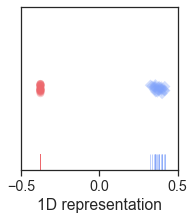

In [9]:
import numpy as np
from scipy.stats import moment
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from os import listdir
import random
from os.path import isfile, join
from sklearn import preprocessing
from sklearn.decomposition import KernelPCA

np.random.seed(200)
sns.set(font_scale=1.3)
sns.set_style("ticks")

number_of_experiment = 50

fig=plt.figure(figsize=(1.4*2, 1.5*2))
mypath = "data"

full_data = []
for size in [8]:
    full_X = []
    label = []
    
    for depth in [5]:
        config = "1D-scramble-Q-size-{}-depth-{}-".format(size, depth)

        list_pred = []
        for b in range(0, 20, 5):
            for i in range(0, 5):
                data = np.load(join(mypath, config+'type-0-batch-{}-number-{}.npy'.format(b, i)))
                data = np.random.permutation(data)[:number_of_experiment]
                feature_vec = np.concatenate((np.mean(data, axis=0), [np.std(np.mean(data, axis=0))]))
                
                full_X.append(feature_vec)
                label.append(["General", depth])

    for depth in [5]:
        config = "1D-scramble-Q-size-{}-depth-{}-".format(size, depth)

        for b in range(0, 20, 5):
            for i in range(0, 5):
                data = np.load(join(mypath, config+'type-1-batch-{}-number-{}.npy'.format(b, i)))
                data = np.random.permutation(data)[:number_of_experiment]
                feature_vec = np.concatenate((np.mean(data, axis=0), [np.std(np.mean(data, axis=0))]))

                full_X.append(feature_vec)
                label.append(["T-symmetry", depth])

    full_X = np.array(full_X)
    min_max_scaler = preprocessing.MinMaxScaler()
    full_X = min_max_scaler.fit_transform(full_X)* 0.8
    transformer = KernelPCA(n_components=2, kernel='rbf')
    X_transformed = transformer.fit_transform(full_X)

    full_data.extend([x + y for x, y in zip(X_transformed.tolist(), label)])
    
df = pd.DataFrame(full_data, columns=['x', 'y', 'Evolution', 'Depth'])


sns.rugplot(data=df[df["Evolution"]=="General"], x="x", hue="Evolution", alpha=.5, height=0.1, palette=["#80A3FA"])
sns.rugplot(data=df[df["Evolution"]=="T-symmetry"], x="x", hue="Evolution", alpha=.5, height=0.1, palette=["#ED686D"])
g = sns.stripplot(data=df[df["Evolution"]=="General"], x="x", hue="Evolution", marker="D", jitter=0.03, size=8, alpha=0.35, palette=["#80A3FA"])
g.set(yticks=[])
g = sns.stripplot(data=df[df["Evolution"]=="T-symmetry"], x="x", hue="Evolution", marker="o", jitter=0.03, size=8, alpha=0.35, palette=["#ED686D"])
g.set(yticks=[])
plt.xlim(-0.5, 0.5)
plt.xlabel("1D representation")
plt.ylabel("")

plt.legend([], [], frameon=[])
